## Example for serving tensorflow models with BentoML
- reference: https://github.com/bentoml/BentoML/tree/main/examples/tensorflow2_keras

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D
from tensorflow.keras import Model

import bentoml

2022-10-08 06:14:20.910036: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


## load example mnist dataset

In [3]:
mnist = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print(f"X train shape: {X_train.shape}")
print(f"y train shape: {y_train.shape}")

print(f"X test shape: {X_test.shape}")
print(f"y test shape: {y_test.shape}")

X train shape: (60000, 28, 28)
y train shape: (60000,)
X test shape: (10000, 28, 28)
y test shape: (10000,)


## preprocess data
- reshape images and normalize to 0~1

In [4]:
# preprocess input images
X_train = X_train.reshape(60000, 28, 28, 1).astype("float32") / 255
X_test = X_test.reshape(10000, 28, 28, 1).astype("float32") / 255

In [5]:
# Reserve 10,000 samples for validation
X_valid = X_train[-10000:]
y_valid = y_train[-10000:]

X_train = X_train[:-10000]
y_train = y_train[:-10000]

## build & train the model

In [6]:
# Create an instance of the model
inputs = Input(shape=(28, 28, 1))
x = inputs
x = Conv2D(32, 3, activation="relu")(x)
x = Flatten()(x)
x = Dense(128, activation="relu")(x)
outputs = Dense(10, activation="sigmoid")(x)

model = Model(inputs, outputs)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    # Loss function to minimize
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    # List of metrics to monitor
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

2022-10-08 06:14:22.234894: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-10-08 06:14:22.235458: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-10-08 06:14:22.580524: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-08 06:14:22.580622: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.62GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2022-10-08 06:14:22.580638: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-10-08 06:14:22.581637: I tensorflow/stream_executor/platform/def

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
flatten (Flatten)            (None, 21632)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               2769024   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 2,770,634
Trainable params: 2,770,634
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=10,
    validation_data=(X_valid, y_valid),
)

2022-10-08 06:14:23.069082: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-10-08 06:14:23.069467: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3000000000 Hz


Epoch 1/10


2022-10-08 06:14:23.287344: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-10-08 06:14:23.417160: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-10-08 06:14:24.022649: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-10-08 06:14:24.051452: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


782/782 [==============================] - 4s 3ms/step - loss: 0.3386 - sparse_categorical_accuracy: 0.8977 - val_loss: 0.0781 - val_sparse_categorical_accuracy: 0.9771
Epoch 2/10
782/782 [==============================] - 1s 2ms/step - loss: 0.0508 - sparse_categorical_accuracy: 0.9850 - val_loss: 0.0650 - val_sparse_categorical_accuracy: 0.9817
Epoch 3/10
782/782 [==============================] - 3s 3ms/step - loss: 0.0253 - sparse_categorical_accuracy: 0.9920 - val_loss: 0.0608 - val_sparse_categorical_accuracy: 0.9829
Epoch 4/10
782/782 [==============================] - 3s 4ms/step - loss: 0.0147 - sparse_categorical_accuracy: 0.9959 - val_loss: 0.0614 - val_sparse_categorical_accuracy: 0.9835
Epoch 5/10
782/782 [==============================] - 3s 4ms/step - loss: 0.0091 - sparse_categorical_accuracy: 0.9977 - val_loss: 0.0657 - val_sparse_categorical_accuracy: 0.9829
Epoch 6/10
782/782 [==============================] - 3s 4ms/step - loss: 0.0069 - sparse_categorical_accuracy:

## report accuracy

In [9]:
pred_train = tf.argmax(model.predict(X_train), axis=1)
pred_valid = tf.argmax(model.predict(X_valid), axis=1)
pred_test = tf.argmax(model.predict(X_test), axis=1)

In [10]:
print(f"train accuracy (%): {tf.reduce_mean(tf.where(y_train == pred_train, 1., 0.))*100:0.4f}")
print(f"valid accuracy (%): {tf.reduce_mean(tf.where(y_valid == pred_valid, 1., 0.))*100:0.4f}")
print(f"test accuracy (%): {tf.reduce_mean(tf.where(y_test == pred_test, 1., 0.))*100:0.4f}")

train accuracy (%): 99.5460
valid accuracy (%): 98.1100
test accuracy (%): 98.1300


## save tensorflow model for later use in BentoService

In [11]:
bentoml.tensorflow.save_model(
    "tensorflow_mnist",
    model,
    signatures={"__call__": {"batchable": True, "batch_dim": 0}},
)

2022-10-08 06:14:56.499915: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/tmpm4_2y1x8bentoml_model_tensorflow_mnist/assets


Model(tag="tensorflow_mnist:q7dqa6cg2cyyiasc", path="/bentoml/models/tensorflow_mnist/q7dqa6cg2cyyiasc/")

## test model loading and inference
- Verify that the model can be loaded as runner from Python shell

In [12]:
import numpy as np
import PIL.Image
import matplotlib.pyplot as plt

In [13]:
runner = bentoml.tensorflow.get("tensorflow_mnist:latest").to_runner()

# for debug only. please do not call this in the service
runner.init_local()

'Runner.init_local' is for debugging and testing only.


In [14]:
imgs = [
    np.array(PIL.Image.open(f"./tensorflow_serving/samples/{i}.png"))
    for i in range(10)
]

In [15]:
arr = np.array(imgs) / 255.
arr = arr.astype("float32")

# add color channel dimension for greyscale image
arr = np.expand_dims(arr, (3))
print(arr.shape)

(10, 28, 28, 1)


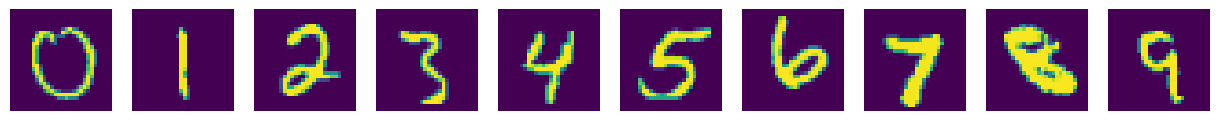

In [16]:
fig, axs = plt.subplots(1, 10)
for i in range(10):
    ax = axs[i]
    ax.imshow(arr[i])
    ax.axis("off")
    
fig.subplots_adjust(right=2)

In [17]:
# returns an array of probabilities for numbers 0-9
pred_probs = runner.run(arr)

In [18]:
pred_labels = np.argmax(pred_probs, axis=1)
print(pred_labels)

[0 1 2 3 4 5 6 7 8 9]
